In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
tickers = np.loadtxt('tickers.csv', dtype=str)
print(tickers[:10])
close = np.loadtxt('close.csv', delimiter=',')
print(close[:10, :10])
print(close.shape)
num_days, num_stocks = close.shape

['MMM' 'AOS' 'ABT' 'ABBV' 'ACN' 'ADBE' 'AMD' 'AES' 'AFL' 'A']
[[136.58026123  43.04999924  75.70999908  78.02999878 178.38999939
  278.25        29.04999924  16.34000015  51.29999924  67.08000183]
 [134.9498291   41.18999863  75.66999817  78.05999756 177.61000061
  273.38000488  28.09000015  16.05999947  51.43000031  67.30000305]
 [134.26422119  41.18999863  76.51999664  77.61000061 178.82000732
  274.51000977  28.03000069  15.89000034  51.56999969  66.88999939]
 [133.57023621  40.5         76.12999725  76.70999908 178.07000732
  270.8999939   27.40999985  15.80000019  51.29999924  67.05000305]
 [133.81271362  41.33000183  75.70999908  75.69999695 175.16000366
  259.02999878  27.57999992  15.93000031  52.43000031  66.98999786]
 [137.3662262   43.15999985  77.45999908  76.75       177.97000122
  268.70999146  29.56999969  16.07999992  53.          67.94999695]
 [136.99832153  43.36999893  78.69000244  77.05999756 179.55999756
  272.85998535  29.5         16.48999977  53.75999832  68.349

best stock is NVDA with total return 4.070293114397691


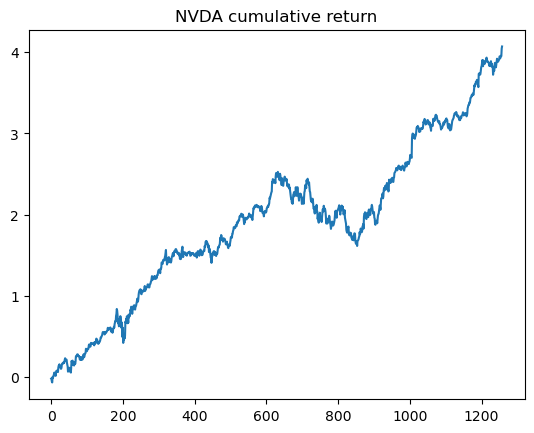

In [49]:
def cum_return(stock, last_day=num_days):
    """
    :param stock: the stock to calculate the cumulative return for
    :param last_day: the last day to calculate the cumulative return for
    :return: the cumulative return for the stock
    """
    close_stock = close[:last_day, stock]
    returns = (close_stock[1:] - close_stock[:-1]) / close_stock[:-1]
    return np.cumsum(returns)

def plot_cum_return(stock):
    cum_returns = cum_return(stock)
    plt.plot(cum_returns)
    plt.title(f'{tickers[stock]} cumulative return')
    plt.show()

def find_best_stock(close=close):
    returns = (close[1:] - close[:-1]) / close[:-1]
    total_return = np.sum(returns, axis=0)
    best_stock = np.argmax(total_return)
    print(f'best stock is {tickers[best_stock]} with total return {total_return[best_stock]}')
    return best_stock

plot_cum_return(find_best_stock())

In [50]:
def equal_portfolio():
    print(f'equal portfolio gets: {np.mean([cum_return(stock)[-1] for stock in range(num_stocks)])}')

equal_portfolio()

equal portfolio gets: 0.7248531005540988


### 1(b)
It makes more sense to take the relative gain $(C_{t+1}(i) - C_t(i)) / C_t(i)$ instead of the unnormalized one, because otherwise we do not have a consistent scaling across stocks, meaning that stocks that have huge values (such as Berkshire part A) will dominate the portfolio, and show huge gains even though relatively speaking we haven't made that much money on it. We care about percentage increase, not just absolute increase, because we can only invest \$1 total each day.

### 1(c)
From the notes we know that the best $\varepsilon$ is just $\sqrt{\log(n)/T}$. For us, we have $n = 419$ stocks who are the experts, and $T = 1259$ days. So we should pick $\sqrt{\log(419)/1259}$. Recall, the multiplicative weights algorithm has gives a regret of $2\sqrt{T \log n}$. For us, is $2\sqrt{1259 \log 419} \approx 174$. Considering how our best performing stock gets a cumulative loss of like 4, this is really bad. We are only required to be within 174 of 4. That's not a very good bound. Presumably our algorithm could give us a return of -173.

In [51]:
def loss(day_t, close=close):
    return -(close[day_t+1] - close[day_t]) / (close[day_t] + 1e-9)

def multiplicative_weights(close=close, eps=None):
    if eps is None:
        eps = np.sqrt(np.log(num_stocks) / num_days)
    weights = np.ones(num_stocks)
    weights /= np.sum(weights)
    losses = []
    for t in range(num_days - 1):
        assert np.allclose(np.sum(weights), 1)
        losses.append(weights @ loss(t,close))
        weights *= np.exp(-eps * loss(t,close))
        weights /= np.sum(weights)

    return weights, np.array(losses)

def plot_multiplicative_weights(close=close):
    final_weights, losses = multiplicative_weights(close)
    plt.plot(np.cumsum(-losses))
    plt.title('negative loss over time')
    plt.show()

### 1(d)


In [52]:
random_close = np.vstack([np.ones(num_stocks, dtype=float), np.random.choice([1., 2.], size=(num_days, num_stocks))])
random_close = np.cumprod(random_close, axis=0)

[0. 1.]


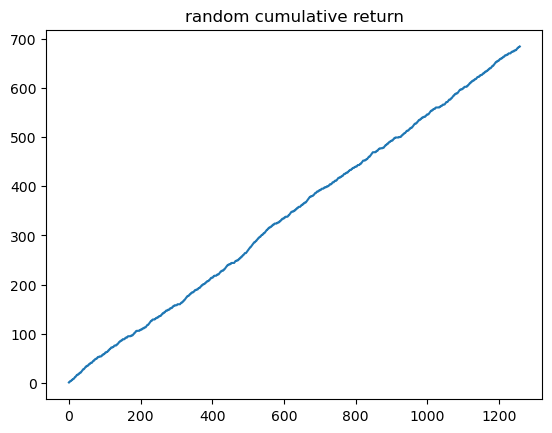

In [53]:
random_returns = (random_close[1:] - random_close[:-1]) / random_close[:-1]
print(np.unique(random_returns))
best_stock_in_hindsight = np.argmax(np.sum(random_returns, axis=0))
# plot the returns of the best stock
plt.plot(np.cumsum(random_returns[:, best_stock_in_hindsight]))
plt.title(f'random cumulative return')
plt.show()

In this case, where each price of the stock is independent of all the ones before it, no algorithm will beat purely random in expectation. Let $w_t$ be the weights of the (randomized) algorithm at time $t$. Conditioning on the stock prices beforehand, by independence we have that:
$$E \left(\sum_{i=1}^n w_t(i) \cdot \frac{C_{t+1}(i) - C_t(i)}{C_t(i)} \mid C_1, \ldots, C_t \right) = \sum_{i=1}^n w_t(i) E \left(\frac{C_{t+1}(i) - C_t(i)}{C_t(i)} \mid C_1, \ldots, C_t \right) = \frac 12 \sum_{i=1}^n w_t(i) = \frac 12.$$
(Note that we can pull the $w_t(i)$ out of the conditional expectation since it is measurable w.r.t. the $C_1, \ldots, C_t$). Thus given any trading strategy, we are incurring a loss of $-\frac12$ at each time step. So any algorithm does equally well/badly in expectation, so really nothing can be done in this case. Of course even the trivial algorithm does as good as this. Nothing we can do here. Note that we can see above, the best performing stock in hindsight reaches a value of 700 or so, and among 1400 days this is like getting $1/2$ per day, which is what we said would happen in expectation. So there is really no way to beat this, and I think that follows by central limit theorem.

### 1(e)
$\varepsilon = 0$ represents when we just don't update the weights at all at each step. We would just take uniform distribution the whole way through. On the other hand, $\varepsilon \to \infty$ would represent just taking the best stock at each time step, and disregarding everything else. Basically it gives the overwhelming majority of the weight to the element that performed best, while completely disregarding everything that performed poorly. This is similar to follow the leader, however follow the leader chooses the best expert based on the expert's total history, while this chooses the best expert based only on the last incremental gain. So $\varepsilon$ in the middle is like a compromise between the two extremes.

# Problem 2

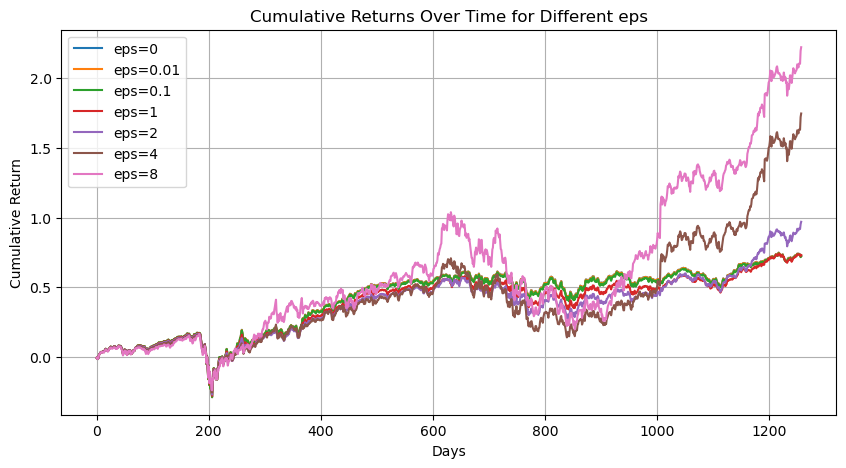

In [54]:
# Define different values of eps to test
eps_values = [0, 0.01, 0.1, 1, 2, 4, 8]

# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    _, losses = multiplicative_weights(close, eps)
    cumulative_returns = -np.cumsum(losses)
    plt.plot(cumulative_returns, label=f"eps={eps}")

# Plot settings
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Over Time for Different eps")
plt.legend()
plt.grid()
plt.show()

### 2(a)
The theoretical best epsilon is $\sqrt{\log(n)/T} = 0.07$. However, you can see  that actually does quite poorly in the above graph. Indeed it even seems like it increases with epsilon. However, the leader among the epsilon changes a lot among the time period. In the real world, NVDA did extremely well in 2024, outperforming like every other stock. So following the leader in that case would give us a great final return. However, throughout the middle, whichever stock was the leader caused gigantic losses for the brown curve. We can also see that the green curve, representative of the right $\epsilon$ is the most stable. This is likely correlated with the theoretical guarantees. I would not have suspected 0.07 to be the best $\epsilon$, because while that gives the best theoretical bound, it is not necessarily the best trading strategy for multiplicative weights.

In [55]:
def multiplicative_weights_diversity(close=close, eps=None):
    if eps is None:
        eps = np.sqrt(np.log(num_stocks) / num_days)
    weights = np.ones(num_stocks)
    weights /= np.sum(weights)
    diversities = []
    for t in range(num_days - 1):
        assert np.allclose(np.sum(weights), 1)
        diversities.append(np.max(weights))
        weights *= np.exp(-eps * loss(t,close))
        weights /= np.sum(weights)
    return diversities

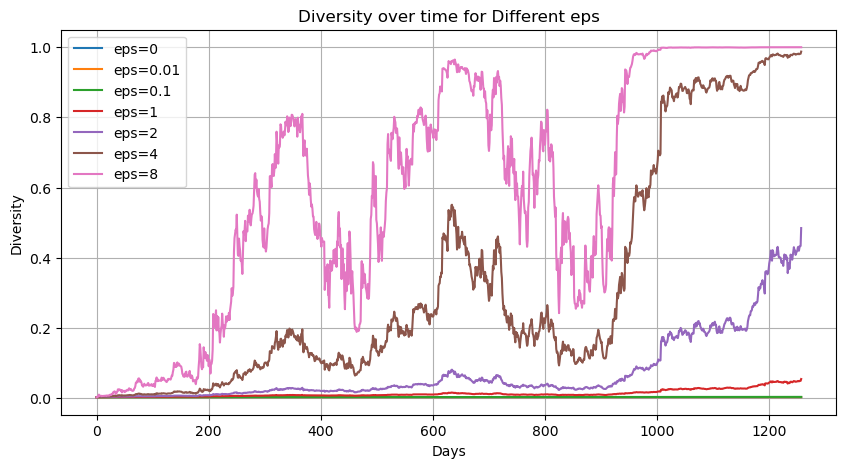

In [56]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    diversities = multiplicative_weights_diversity(close, eps)
    plt.plot(diversities, label=f"eps={eps}")

# Plot settings
plt.xlabel("Days")
plt.ylabel("Diversity")
plt.title("Diversity over time for Different eps")
plt.legend()
plt.grid()
plt.show()

### 2(b)
This is quite an instructive graph. With this measure of diversity, we can see that the green line, was our theoretical bound, has a very small, almost constant max probability throughout. This is definitely why its a lot more stable than the others. The brown curve, representing the largest epsilon, is very not diverse. Near the end, its clearly assigning all its weight to one stock. It also does this pretty frequently throughout, which is very risky. The purple exhibits similar behavior, and the red one does too but to a much lesser extent, never actually exceeding like 0.5. I would say the red still invests in a few stocks, but not nearly as much as the green curve. The brown stock is just basically prioritizing one stock the whole time.

### 2(c) No NVDA

In [107]:
close_no_nvda = np.copy(close)
close_no_nvda[:, list(tickers).index('NVDA')] = 0
print(close_no_nvda.shape)

(1259, 419)


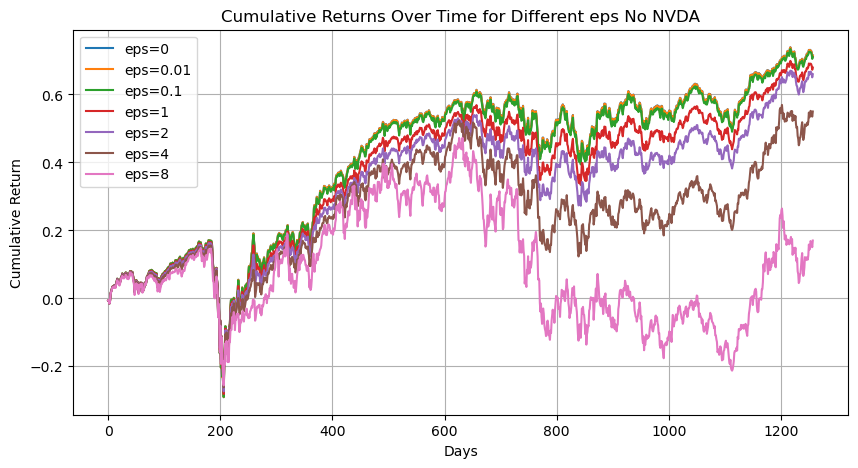

In [108]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    _, losses = multiplicative_weights(close_no_nvda, eps)
    cumulative_returns = -np.cumsum(losses)
    plt.plot(cumulative_returns, label=f"eps={eps}")

# Plot settings
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Over Time for Different eps No NVDA")
plt.legend()
plt.grid()
plt.show()

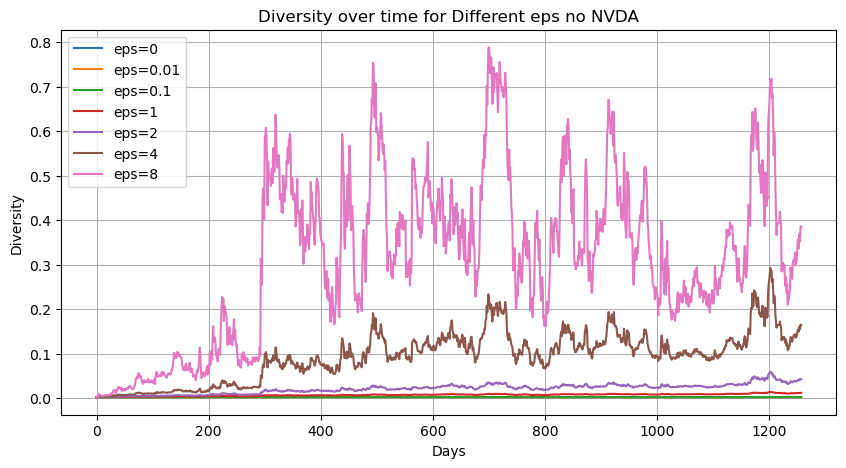

In [109]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    diversities = multiplicative_weights_diversity(close_no_nvda, eps)
    plt.plot(diversities, label=f"eps={eps}")

# Plot settings
plt.xlabel("Days")
plt.ylabel("Diversity")
plt.title("Diversity over time for Different eps no NVDA")
plt.legend()
plt.grid()
plt.show()

Wow. NVDA totally changes the effectiveness of our algorithm vs epsilon. As you can see, if we remove the one super outlier NVDA, the best epsilon suddenly becomes $0.1$ as we would expect! Also, for the diversities, the brown curve still seems to really prioritize one stock, with probablities very frequently above 0.7, while the same effect on purple is greatly reduced. For red, its almost gone, and as before green / orange / blue are the same. NVDA was really fueling big gains for the risky strategy!

### 2(d)
Multiplicative weights, with the correctly chosen $\varepsilon$, actually works quite well. When we pick the epsilon that should be good in theory, it has a lot of diversity, relatively stable, and fuels some good long term gains. However, this method would certainly miss out on a stock explosion like NVDA, because it puts a lot of effort into being stable. Removing NVDA, and suddenly the model does really well. If I wanted to just invest my retirement savings, have it be somewhat stable while still able to fuel big gains, I would use this method with a small epsilon. On the other hand, if I wanted to play the risky game, I would use a huge epsilon, and probably suffer huge losses like during COVID. The results, just removing NVDA and the return gains basically flipping as a function of epsilon, was really surprising. Independent of the algorithm, this shows how much of a powerhouse NVDA has become. But the COVID crash shows how important it is to be diversified, so you don't lose all your money chasing the big guy.

### 2(e)
The model in theory treats all losses equally over time. Indeed, at time step $s$, the total loss incurred by our algorithm is
$$\sum_{t \leq s} E_{i \sim p_t}(l_t(i)).$$ In particular, independent of $t$ the coefficient of $E_{i \sim p_t}(l_t(i))$ is the same. However, it does make sense to treat recent losses more heavily. The performance of the stock is much more relevant to the recent past than the distant past. For example, if a penny stock got a giant government contract, and exploded 100x in value, it's changes when it was still a penny stock aren't symbolic of how its going to do anymore. So we really shouldn't be worried about that loss as much, we should be caring more about the recent losses. I propose the following fix to this. Instead of incurring the loss $E_{i \sim p_t}(l_t(i))$, at time step $t$, I say we should incur $E_{i \sim p_t}(tl_t(i))$, so the loss gets bigger with time. This way we are more sensitive to recent losses.

In [123]:
def multiplicative_weights_time_sensitive(close=close, eps=None):
    if eps is None:
        eps = np.sqrt(np.log(num_stocks) / num_days)
    weights = np.ones(num_stocks)
    weights /= np.sum(weights)
    losses = []
    for t in range(num_days - 1):
        #assert np.allclose(np.sum(weights), 1)
        # loss_t = (t+1) * loss(t,close)
        losses.append(weights @ loss(t,close))
        weights = np.power(weights, 1 - eps * np.min(loss(t,close)))
        weights *= np.exp(-eps * loss(t,close))
        weights /= np.sum(weights)
    if np.allclose(eps, 0.01):
        print(tickers[np.argmax(weights)])
    return np.array(losses)

NVDA


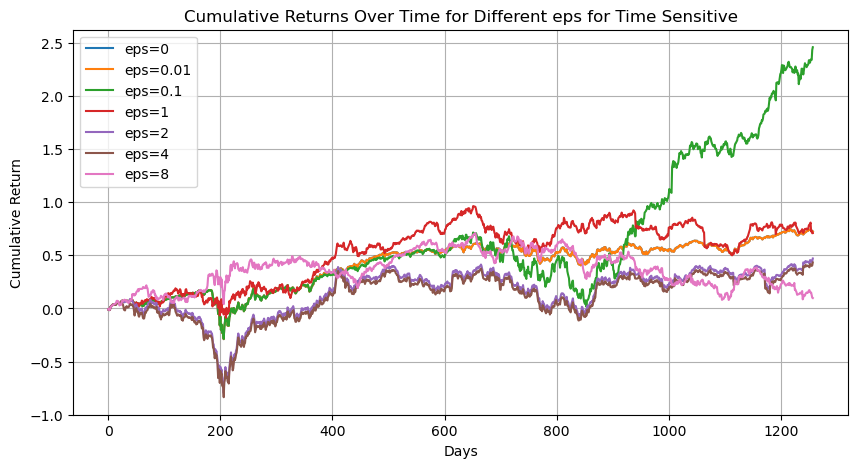

In [124]:
eps_values = [0, 0.01, 0.1, 1, 2, 4, 8]
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    losses = multiplicative_weights_time_sensitive(close, eps)
    cumulative_returns = -np.cumsum(losses)
    plt.plot(cumulative_returns, label=f"eps={eps}")
#
# Plot settings
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Over Time for Different eps for Time Sensitive")
plt.legend()
plt.grid()
plt.show()

In [125]:
def multiplicative_weights_time_sensitive_diversity(close=close, eps=None):
    if eps is None:
        eps = np.sqrt(np.log(num_stocks) / num_days)
    weights = np.ones(num_stocks)
    weights /= np.sum(weights)
    diversities = []
    for t in range(num_days - 1):
        assert np.allclose(np.sum(weights), 1)
        diversities.append(np.max(weights))
        weights = np.power(weights, 1 - eps * np.min(loss(t,close)))
        weights *= np.exp(-eps * loss(t,close))
        weights /= np.sum(weights)
    return diversities

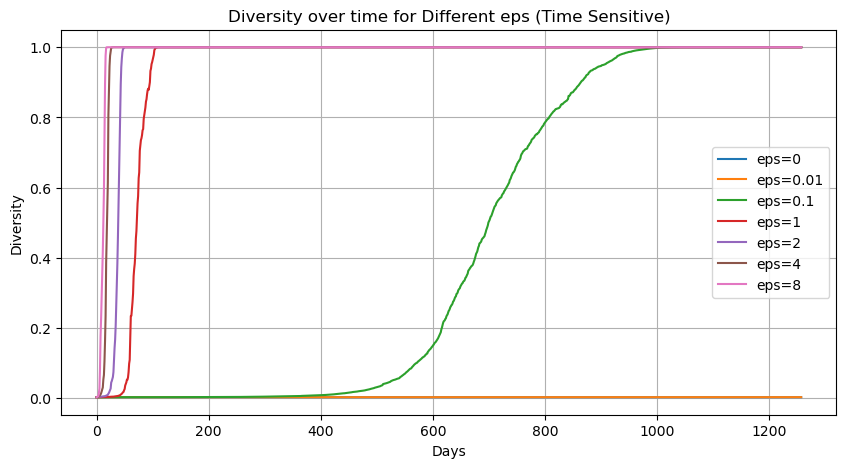

In [126]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    diversities = multiplicative_weights_time_sensitive_diversity(close, eps)
    plt.plot(diversities, label=f"eps={eps}")

# Plot settings
plt.xlabel("Days")
plt.ylabel("Diversity")
plt.title("Diversity over time for Different eps (Time Sensitive)")
plt.legend()
plt.grid()
plt.show()

KLAC


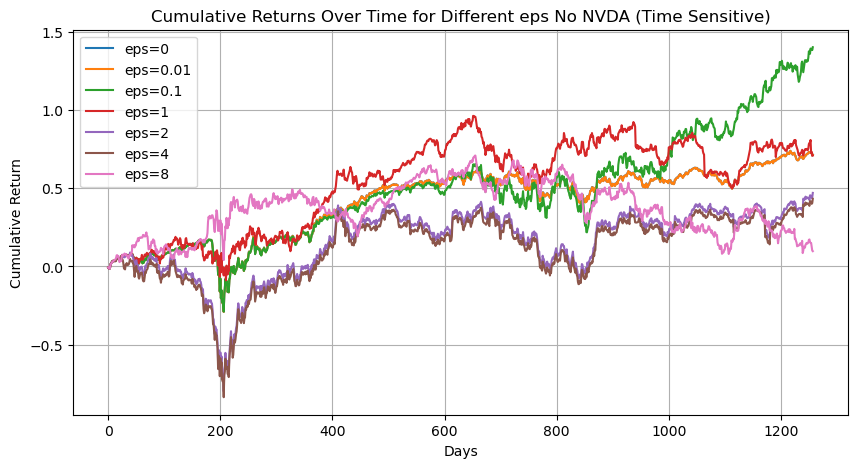

In [127]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    losses = multiplicative_weights_time_sensitive(close_no_nvda, eps)
    cumulative_returns = -np.cumsum(losses)
    plt.plot(cumulative_returns, label=f"eps={eps}")
#
# Plot settings
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Over Time for Different eps No NVDA (Time Sensitive)")
plt.legend()
plt.grid()
plt.show()

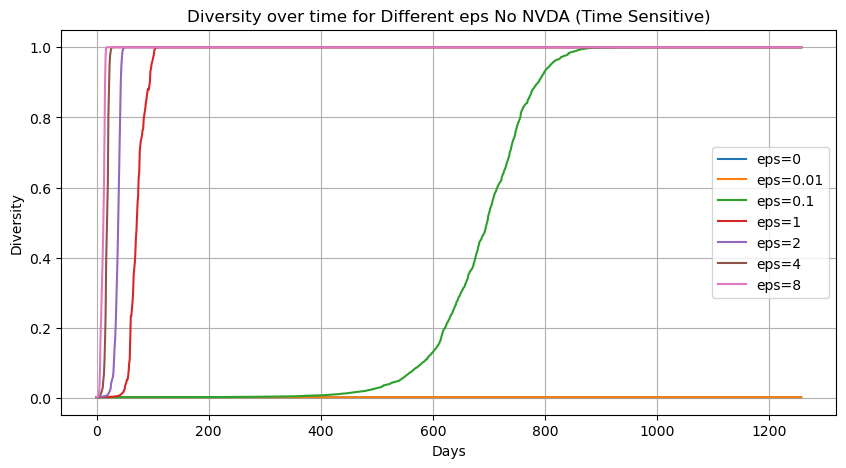

In [115]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    diversities = multiplicative_weights_time_sensitive_diversity(close_no_nvda, eps)
    plt.plot(diversities, label=f"eps={eps}")

# Plot settings
plt.xlabel("Days")
plt.ylabel("Diversity")
plt.title("Diversity over time for Different eps No NVDA (Time Sensitive)")
plt.legend()
plt.grid()
plt.show()

In [116]:
def multiplicative_weights_time_sensitive_2(close=close, eps=None):
    if eps is None:
        eps = np.sqrt(np.log(num_stocks) / num_days)
    weights = np.ones(num_stocks)
    weights /= np.sum(weights)
    losses = []
    for t in range(num_days - 1):
        assert np.allclose(np.sum(weights), 1)
        max_loss = np.max(np.abs(loss(t,close)))
        print(max_loss)
        losses.append(weights @ loss(t,close))
        weights = np.power(weights, 1/max_loss)
        weights *= np.exp(-eps * loss(t,close))
        weights /= np.sum(weights)
    return np.array(losses)

def multiplicative_weights_time_sensitive_diversity_2(close=close, eps=None):
    if eps is None:
        eps = np.sqrt(np.log(num_stocks) / num_days)
    weights = np.ones(num_stocks)
    weights /= np.sum(weights)
    diversities = []
    for t in range(num_days - 1):
        assert np.allclose(np.sum(weights), 1)
        diversities.append(np.max(weights))
        weights *= np.exp(-eps * (t+1) * loss(t,close))
        weights /= np.sum(weights)
    return diversities

0.07060756529055721
0.11299355784946245
0.07648949550370175
0.17815368733099413
0.08979437172029628
0.10023614887285995
0.07864405744900253
0.05314538173492457
0.058198435477280167
0.04278158298774634
0.05649565679534939
0.06398713011720335
0.05650115021766848
0.05567556052195295
0.0573543198517132
0.05890430876892601
0.08181475604102732
0.044966143990497746
0.07417916165421744
0.16252390689383145
0.13341495010719512
0.12098167863665192
0.06734006849178575
0.06004927165218502
0.06164387319578743
0.13574660398556712
0.045968832006190515
0.0473657476317279
0.05332371057325545
0.04972807684547387
0.09239301189017673
0.16116706615731188
0.10676572447054657
0.05765003196029974
0.10270270464288853
0.10272047990134363
0.06732991390686865
0.09149424234605379
0.0995299530886078
0.10458715361992657
0.2698793748256554
0.17600411975480013
0.1256772327794213
0.19018334231279707
0.10097426267187738
0.10793155975271043
0.2022179579601311
0.07664190250810228
0.15946841990365931
0.08204574780506829
0.1

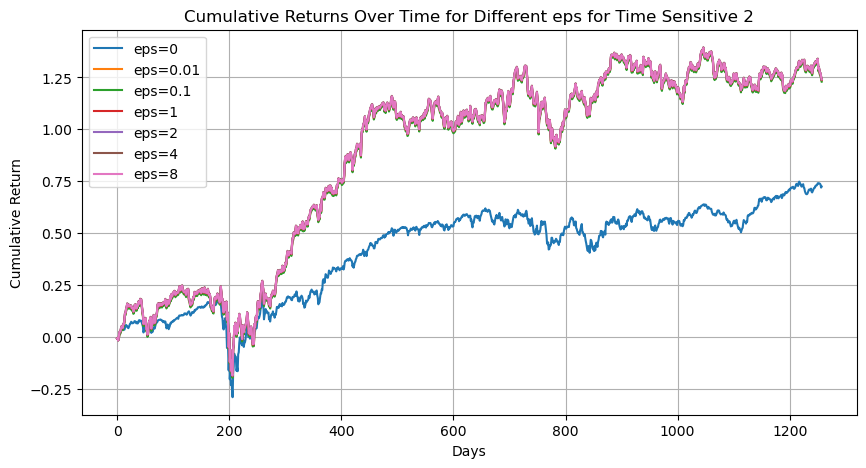

In [117]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Iterate over different eps values
for eps in eps_values:
    losses = multiplicative_weights_time_sensitive_2(close, eps)
    cumulative_returns = -np.cumsum(losses)
    plt.plot(cumulative_returns, label=f"eps={eps}")
#
# Plot settings
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Over Time for Different eps for Time Sensitive 2")
plt.legend()
plt.grid()
plt.show()